## Install the package dependencies before running this notebook

In [1]:
import torch.nn as nn

In [2]:
import torch
import math
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy as np
import pickle
from glob import glob
import csv
from collections import OrderedDict
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import threading
"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [3]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = ROOT_PATH + split + "/" + city + "_inputs"
#     print(f_in)
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs)
    
    outputs = None
    
    if split=="train":
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.split = split
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == 'test':
            data = (self.inputs[idx],)
        else:
            data = (self.inputs[idx], self.outputs[idx])
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'


train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [4]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Sample a batch of data and visualize 

torch.Size([4, 50, 2])


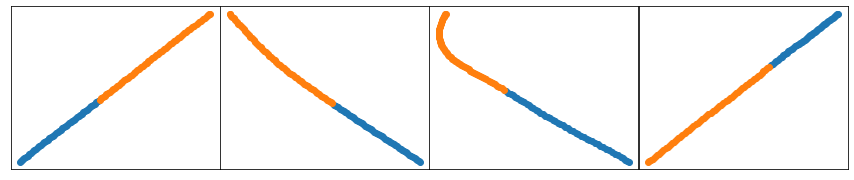

In [5]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape)
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

In [6]:
cities = ['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto']  
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686}
# cities.index('austin')

def minMaxDistance(t):
    """
    N * 50 * 2
    """
    max_x = torch.max(t[:, :, 0]).item()
    min_x = torch.min(t[:, :, 0]).item()
    max_y = torch.max(t[:, :, 1]).item()
    min_y = torch.min(t[:, :, 1]).item()
    
#     return max(max_x - min_x, max_y - min_y)
    return t.max(), t.min(), t.mean()
    
for i in range(6):
    cur_train_dataset  = ArgoverseDataset(city = cities[i], split = 'train')
    cur_train_loader = DataLoader(cur_train_dataset,batch_size=len(cur_train_dataset))

    for _, batch in enumerate(cur_train_loader):
        bd, bl = batch
        print(minMaxDistance(bd))
        print(minMaxDistance(bl))
    

(tensor(4241.4881, dtype=torch.float64), tensor(-4211.2554, dtype=torch.float64), tensor(-21.6043, dtype=torch.float64))
(tensor(4212.1240, dtype=torch.float64), tensor(-4204.3831, dtype=torch.float64), tensor(-21.5349, dtype=torch.float64))
(tensor(7315.4776, dtype=torch.float64), tensor(-9222.6147, dtype=torch.float64), tensor(1691.3345, dtype=torch.float64))
(tensor(7321.2642, dtype=torch.float64), tensor(-9231.7557, dtype=torch.float64), tensor(1691.4807, dtype=torch.float64))
(tensor(8027.5602, dtype=torch.float64), tensor(-1824.8782, dtype=torch.float64), tensor(2201.0815, dtype=torch.float64))
(tensor(7998.1668, dtype=torch.float64), tensor(-1826.5366, dtype=torch.float64), tensor(2199.9029, dtype=torch.float64))
(tensor(13295.1069, dtype=torch.float64), tensor(-6052.9875, dtype=torch.float64), tensor(5190.1355, dtype=torch.float64))
(tensor(13318.4676, dtype=torch.float64), tensor(-6023.6660, dtype=torch.float64), tensor(5189.8673, dtype=torch.float64))
(tensor(6985.2479, dtype

In [7]:
def showDimensions():
    # show training
    print("Training data/label dimensions and size:")
    total = 0
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "train")
        cur_loader = DataLoader(cur_dataset,batch_size=len(cur_dataset)) 
        print("====================" + cities[i] + "====================")
        for _, batch in enumerate(cur_loader):
            bd, bl = batch
            
            print("data shape: {}, size: {}".format(bd.shape, len(bd)))
            print("label shape: {}, size: {}".format(bl.shape, len(bl)))
            total += bd.shape[0]
    print("Total:" + str(total))

showDimensions()

Training data/label dimensions and size:
====================austin====================
data shape: torch.Size([43041, 50, 2]), size: 43041
label shape: torch.Size([43041, 60, 2]), size: 43041
====================miami====================
data shape: torch.Size([55029, 50, 2]), size: 55029
label shape: torch.Size([55029, 60, 2]), size: 55029
====================pittsburgh====================
data shape: torch.Size([43544, 50, 2]), size: 43544
label shape: torch.Size([43544, 60, 2]), size: 43544
====================dearborn====================
data shape: torch.Size([24465, 50, 2]), size: 24465
label shape: torch.Size([24465, 60, 2]), size: 24465
====================washington-dc====================
data shape: torch.Size([25744, 50, 2]), size: 25744
label shape: torch.Size([25744, 60, 2]), size: 25744
====================palo-alto====================
data shape: torch.Size([11993, 50, 2]), size: 11993
label shape: torch.Size([11993, 60, 2]), size: 11993
Total:203816


In [7]:
def getDistribution(t):
    minVal = math.floor(t.min())
    maxVal = math.ceil(t.max())

    coords = OrderedDict()
    
    #print(t.shape)
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            c = t[i, j];
            #print(c)
            x = round(c[0].item())
            y = round(c[1].item())
            
            if (x, y) not in coords:
                coords[(x, y)] = 1
            else:
                coords[(x, y)] += 1
    
    converted = {'x':[], 'y':[], 'count':[]}
    #print(coords)
    for x, y in coords:
        converted['x'].append(x)
        converted['y'].append(y)
        converted['count'].append(coords[(x, y)])
    
    
    return pd.DataFrame(data=converted)


In [8]:
def showDistribution(d):
    ax = sns.heatmap(d.pivot("y", "x", "count"), )
    ax.invert_yaxis()
    plt.show()


In [9]:


def getTrainingTensor(denom=1000):
    total = 0
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "train")
        total += len(cur_dataset)

    data_tensor = torch.zeros(total, 50, 8, dtype=torch.float)
    label_tensor = torch.zeros(total, 60, 2, dtype=torch.float)
    counts = {}
    cur_ind = 0
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "train")
        cur_loader = DataLoader(cur_dataset,batch_size=len(cur_dataset))
        
        
        for _, batch in enumerate(cur_loader):
            bd, bl = batch
            N = bd.shape[0]
            city_tensor = torch.zeros(N, 50, 6)
            city_tensor[:, :, i] = 1
            counts[cities[i]] = N
            data_tensor[cur_ind:cur_ind+N, :, :] = torch.cat((bd/denom, city_tensor), axis=2)
            label_tensor[cur_ind:cur_ind+N, :, :] = bl/denom
            cur_ind += N
            
    return data_tensor, label_tensor, counts

data_tensor, label_tensor, counts = getTrainingTensor()
     
random_indexes = torch.randperm(data_tensor.shape[0])
data_tensor = data_tensor[random_indexes]
label_tensor = label_tensor[random_indexes]
    

================== Overall =======================
input distribution:


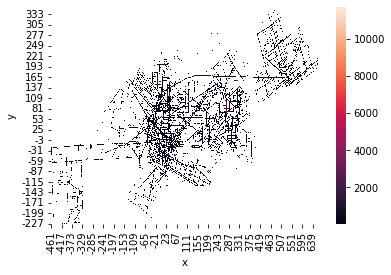

output distribution:


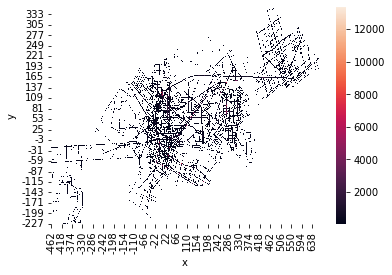

In [13]:
# Overall input distribution
print("==================", "Overall", "=======================")
print("input distribution:")
showDistribution(getDistribution(data_tensor*50))
# Overall output distribution
print("output distribution:")
showDistribution(getDistribution(label_tensor*50))

================== austin =======================
input distribution:


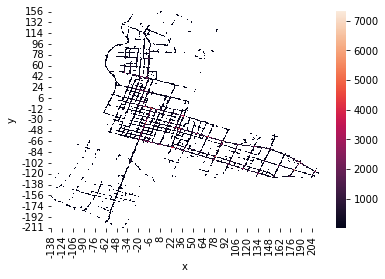

output distribution:


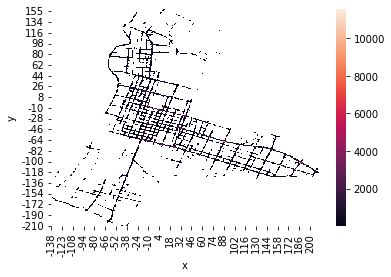

================== miami =======================
input distribution:


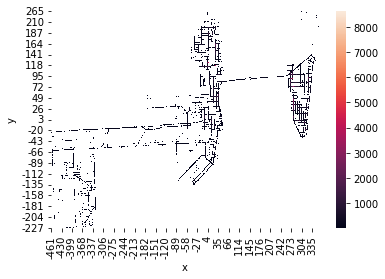

output distribution:


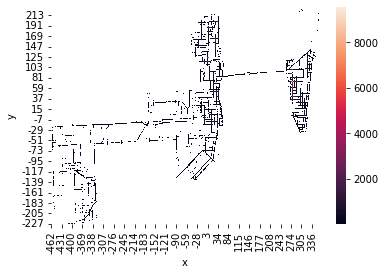

================== pittsburgh =======================
input distribution:


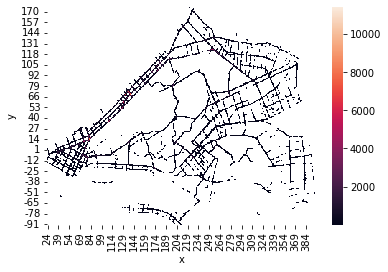

output distribution:


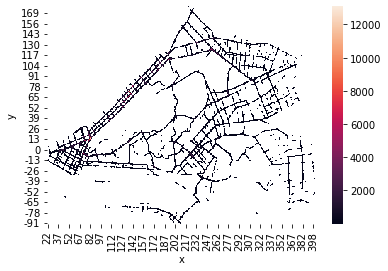

================== dearborn =======================
input distribution:


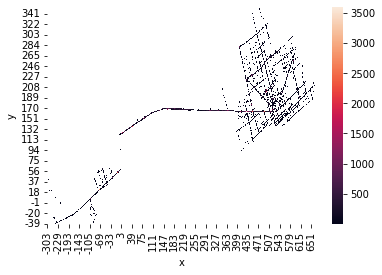

output distribution:


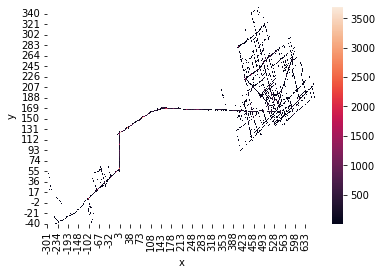

================== washington-dc =======================
input distribution:


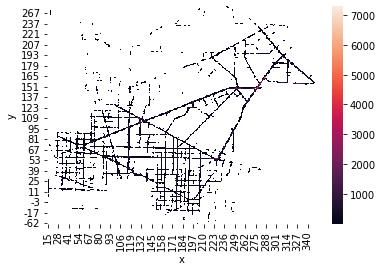

output distribution:


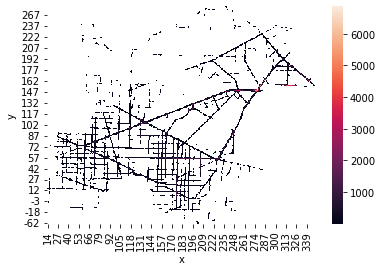

================== palo-alto =======================
input distribution:


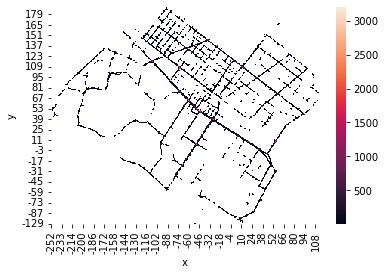

output distribution:


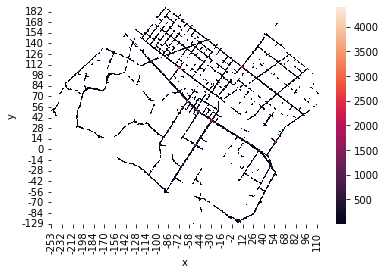

In [14]:
def showCitiesDistributions():
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "train")
        cur_loader = DataLoader(cur_dataset,batch_size=len(cur_dataset))
        print("==================", cities[i], "=======================")
        for _, batch in enumerate(cur_loader):
            bd, bl = batch
            print("input distribution:")
            showDistribution(getDistribution(bd/20))
            print("output distribution:")
            showDistribution(getDistribution(bl/20))
showCitiesDistributions()

In [17]:
MAX_i = 100000
MIN_i = -100000

# get all dataset
split = 'train'

train_data = []
len_train_data_input = 0
len_train_data_output = 0
inputs_location_range = dict()
outputs_location_range = dict()

for city in cities:
    data = ArgoverseDataset(city = city, split = split)
    train_data.append(data)
    len_train_data_input += len(data.inputs)
    len_train_data_output += len(data.outputs)
    for locs in data.inputs:
        cur_i,cur_j = MAX_i, MIN_i
        for loc in locs:
            if loc[0] < cur_i:
                cur_i = loc[0]
            if loc[1] > cur_j:
                cur_j = loc[1]
        if city in inputs_location_range:
            inputs_location_range[city].append([cur_i, cur_j])
        else:
            inputs_location_range[city] = [[cur_i, cur_j]]
    
    for locs in data.outputs:
        cur_i,cur_j = MAX_i, MIN_i
        for loc in locs:
            if loc[0] < cur_i:
                cur_i = loc[0]
            if loc[1] > cur_j:
                cur_j = loc[1]
        if city in outputs_location_range:
            outputs_location_range[city].append([cur_i, cur_j])
        else:
            outputs_location_range[city] = [[cur_i, cur_j]]
    

split = 'test'
test_data = []
len_test_data_input = 0
len_test_data_output = 0

for city in cities:
    data = ArgoverseDataset(city = city, split = split)
    test_data.append(data)
    len_test_data_input += len(data.inputs)
    for locs in data.inputs:
        cur_i,cur_j = MAX_i, MIN_i
        for loc in locs:
            if loc[0] < cur_i:
                cur_i = loc[0]
            if loc[1] > cur_j:
                cur_j = loc[1]         
        if city in inputs_location_range:
            inputs_location_range[city].append([cur_i, cur_j])
        else:
            inputs_location_range[city] = [[cur_i, cur_j]]
   
print("train data size is ", len_train_data_input)
print("test data size is ", len_test_data_input)
print("dimensions of inputs is ({}, {}, {})".format(len(train_data[0].inputs), len(train_data[0].inputs[0]), len(train_data[0].inputs[0][0])))
print("dimensions of outputs is ({}, {}, {})".format(len(train_data[0].outputs), len(train_data[0].outputs[0]), len(train_data[0].outputs[0][0])))

train data size is  203816
test data size is  29843
dimensions of inputs is (43041, 50, 2)
dimensions of outputs is (43041, 60, 2)


In [18]:
print(inputs_location_range.keys())
print(outputs_location_range.keys())

lists = []
for key in inputs_location_range.keys():
    lists.append(inputs_location_range[key])

dict_keys(['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto'])
dict_keys(['austin', 'miami', 'pittsburgh', 'dearborn', 'washington-dc', 'palo-alto'])


(49366, 2)


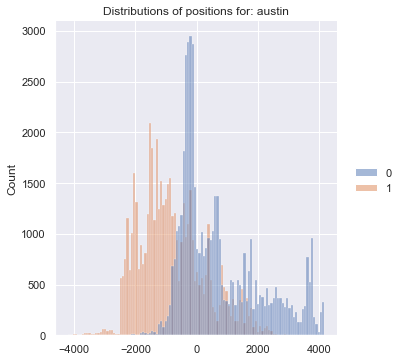

(63000, 2)


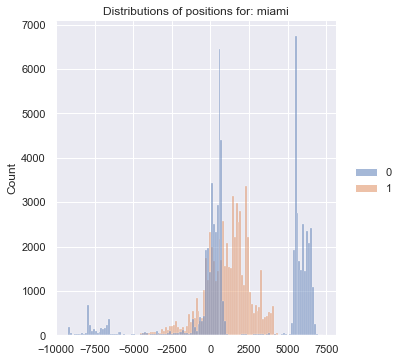

(49905, 2)


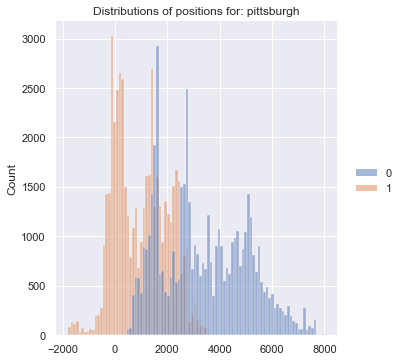

(28136, 2)


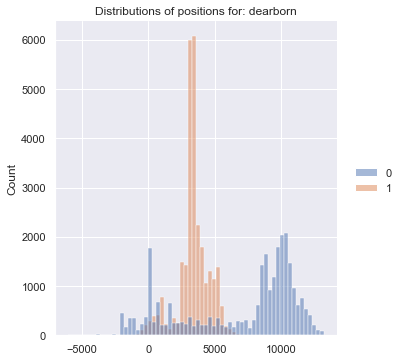

(29573, 2)


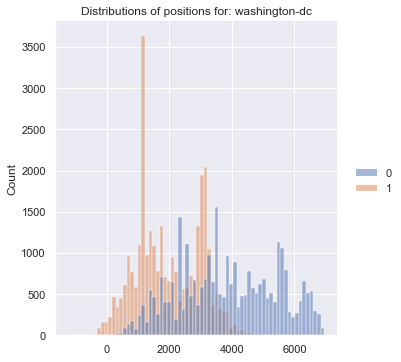

(13679, 2)


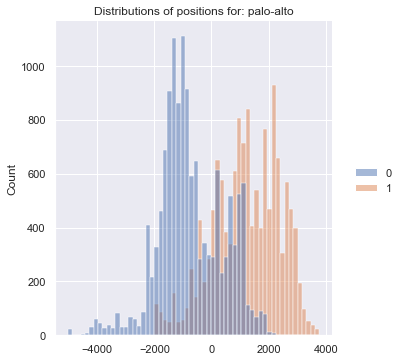

In [19]:

for city in inputs_location_range.keys():
    df = np.array(inputs_location_range[city])
    print(df.shape)

    sns.set()
    ax = sns.displot(df)
    title = "Distributions of positions for: " + city
    plt.title(title)
    plt.show()


### Model

In [10]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    dev = torch.device('cuda:1')

class TrajectoryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, mlp_internal_size, output_size, seq_len, out_seq_len, device=dev):
        super(TrajectoryPredictor, self).__init__()
        
        self.device = device
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.out_seq_len = out_seq_len
        self.input_size = input_size
        self.output_size = output_size

        
        self.lstm_cell = nn.LSTM(input_size, hidden_size, 1, bidirectional=True, batch_first=True) 
        
        self.output = nn.Sequential(
            nn.Linear(self.hidden_size*2, output_size)
        )
        self.softmax = nn.Softmax(dim=1)        
        
        # Simple attention
        self.attention_mlp = nn.Sequential(
            nn.Linear(seq_len*hidden_size*2, seq_len*out_seq_len),
            nn.ReLU(),
        )
        self.attention_softmax = nn.Softmax(dim=1)
        
        # Generator
        self.lstm2 = nn.LSTM(self.hidden_size*2 + output_size, hidden_size, 1, batch_first=True)
        self.output2 = nn.Sequential(
            nn.Linear(self.hidden_size, mlp_internal_size),
            nn.ReLU(),
            nn.Linear(mlp_internal_size, output_size)
        )      

    
    def encode(self, x):
        N = x.shape[0]
        self.batch_size = N
        h0 = torch.zeros(2, N, self.hidden_size, dtype=torch.float).to(self.device)
        c0 = torch.zeros(2, N, self.hidden_size, dtype=torch.float).to(self.device)
        # out: N * 40 * hidden
        # hm, cm: 1 * N * hidden 
        out, (hm, cm) = self.lstm_cell(x, (h0, c0))
        
        # N * (40 * hidden)
        att = out.reshape(N, -1)
        
        att = self.attention_mlp(att)
        att = att.reshape(N, self.seq_len, self.out_seq_len)
        att = self.attention_softmax(att)
        
        att = att.reshape(N, self.seq_len, 1, self.out_seq_len)\
            .broadcast_to(N, self.seq_len, self.hidden_size*2, self.out_seq_len)
        
        # N * 40 * hidden * 200 -> N * hidden * 200
        #print(out.shape, att.shape)
        att_res = (out.reshape(N, self.seq_len, self.hidden_size*2, 1)\
                   .broadcast_to(N, self.seq_len, self.hidden_size*2, self.out_seq_len) * att).sum(axis=1)
        
        out = self.output(out[:, -1, :].reshape(N, self.hidden_size*2))
#         out = self.softmax(out/self.t)
        return out, att_res, (hm[0].reshape(1, hm.shape[1], hm.shape[2]), cm[0].reshape(1, cm.shape[1], cm.shape[2]))
        
    def generate(self, out, att_res, i, hm, cm):   
        N = self.batch_size
        #print(i)
        # out: N * 1 * hidden, 1 * N * hidden for the others
        #print(att_res.shape)
        out = torch.cat((att_res[:, :, i], out), 1)
        #print(out.shape)
        out, (hm, cm) = self.lstm2(out.reshape(N, 1, out.shape[1]), 
                                   (hm, cm))
        # N * output_size
        # print(out.shape, "N:", N)
        out = self.output2(out.reshape(N, self.hidden_size))
        # print(out.shape)
        return out.reshape(N, out.shape[-1]), (hm, cm)
#         out = self.softmax(out/self.t)
#         #print(out.shape)
#         results[:, i, :] = out.reshape(N, out.shape[-1])   
        
    


In [ ]:
def splitData(training_tensor, training_label_tensor, valid_pos = 0):
    """
    valid_pos: 0 - 4, 5 folds
    """

    training_counts = [(valid_pos*int(n*0.2),valid_pos*int(n*0.2)+int(n*0.2)) for n in counts.values()]
    
    
    training_indexes = []
    valid_indexes = []
    sample_counts = [0 for i in range(6)]
    for i in range(len(training_tensor)):
        cityIndex = training_tensor[i, 0, 2:].argmax()
        #print(cityIndex)
        sample_counts[cityIndex] += 1
        
        if sample_counts[cityIndex] >= training_counts[cityIndex][0] \
            and sample_counts[cityIndex] < training_counts[cityIndex][1]:
            valid_indexes.append(i)
        else:
            training_indexes.append(i)
    
    return training_tensor[training_indexes], training_label_tensor[training_indexes],\
            training_tensor[valid_indexes], training_label_tensor[valid_indexes]

training_tensor, training_label_tensor,valid_tensor, valid_label_tensor = splitData(data_tensor, label_tensor, valid_pos=4)
    



In [ ]:
print(training_tensor.shape, training_label_tensor.shape)
print(valid_tensor.shape, valid_label_tensor.shape)

In [11]:
def train(data, labels, model = None, epoch=100, lr=0.0005, batch_size=32, lm=0.0001, default_dev=dev):
    """
    data: # of samples * seq_len * # of features(42), 3d list
    labels: # of samples # out_seq_len * # of features(39)
    """
    """
    input_size: x, y, city_onehot(6) -> 8 in total
    hidden: 32
    internal_mlp: 8
    final output: 2
    input sequence: 50
    output sequence: 60
    """
    
    if model == None:
        model = TrajectoryPredictor(8, 64, 16, 2, 50, 60)
    model.device = default_dev
    n = len(data)
    #print(n)
    num_batches = math.ceil(n / batch_size)
    model.to(default_dev)
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True)
    #dir(scheduler)
    for e in range(epoch):
        print("============================== Epoch {} ==============================".format(e))
        avg_loss = 0
        last_loss = 0
        for i in range(num_batches):           
            start = i * batch_size
            end = start + batch_size #excluded
            if end > n:
                end = n
            #expected sequence of length 40 at dim 1 (got 41)
            #print(data[start:end])
#             if i == 13:
#                 for j in range(start, end):
#                     string = ''
#                     for k in range(len(data[j])):
#                         #print(j, k, torch.tensor(data[j][k]).argmax().item())
#                         string += dictionary[torch.tensor(data[j][k][:39]).argmax().item()]
#                     print(string, "len:", len(string))
                    
#             batch_data = torch.tensor(data[start:end], dtype=torch.float, device=default_dev)
            #print(data.shape)
            batch_data = data[start:end].to(default_dev)
            #print(start, end, batch_data.shape)
            # N * 200 
            #batch_labels = torch.tensor(labels[start:end], dtype=torch.float, device=default_dev).argmax(axis=2)
            batch_labels = labels[start:end].to(default_dev)
            
            out, att_res, mem = model.encode(batch_data)
            loss = 0
            for j in range(60):    
                out, mem = model.generate(out, att_res, j, *mem)
                #print(out.shape, batch_labels.shape)
                loss += loss_function(out, batch_labels[:, j, :]) 
            
            # L2 regularizer
            l2_loss = 0
            for param in model.parameters():
                l2_loss += torch.pow(param, 2).sum()
            
            loss += lm * l2_loss           
            
            optimizer.zero_grad()
            loss.backward()

            #print(list(model.parameters())[0].grad)
            optimizer.step()
            
            
            
            with torch.no_grad():
                if i % 100 == 0 and i != 0:
#                     pass
                    print("Epoch {} Batch {} loss:{} l2_loss:{}".format(e, i, loss.item()/60, l2_loss.item()))
                avg_loss += loss.item()
                last_loss = loss.item()
        avg_loss /= num_batches
        scheduler.step(avg_loss)
        print("Average Loss: {}".format(avg_loss/60))
        print("last_loss: {}".format(last_loss/60))
    return model

In [13]:
model = train(data_tensor, label_tensor, model=TrajectoryPredictor(8, 128, 16, 2, 50, 60), epoch=100, batch_size=32, lm=0.000001, lr=0.0001)


============================== Epoch 0 ==============================


KeyboardInterrupt: 

In [22]:
def calculateRMSE(loss, l2_loss, lm):
    return math.sqrt((loss*60 - l2_loss * lm) * 1000**2)
    

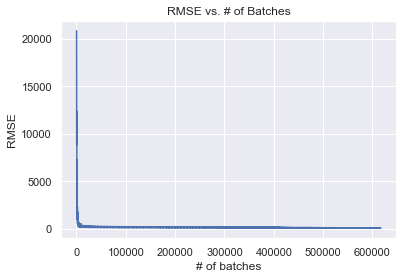

In [23]:
def plotFirst100MSE(lm=0.000001):
    rmses = []
    with open("./milestone/first100log", "r") as fp:
        count = 0
        for line in fp:
            if (line.startswith("Epoch")):
                str_list = line.strip().split(":")
                l2_loss = float(str_list[-1])
                loss = float(str_list[-2].split(" ")[0])
                rmses.append(calculateRMSE(loss, l2_loss, lm))
                count += 1
                
    plt.plot([(i+1)*100 for i in range(count)], rmses)
    plt.xlabel('# of batches')
    plt.ylabel('RMSE')
    plt.title("RMSE vs. # of Batches")
    plt.show()
    
    
plotFirst100MSE()

In [ ]:

def run_latest(model=None,epoch=600, batch_size=32, lm=0.00000001, lr=0.00000001, default_dev='cuda:1'):
    
    if torch.cuda.is_available():
        dev = torch.device(default_dev)
    else:
        dev = torch.device('cpu')
    if model is None:
        model = TrajectoryPredictor(8, 64, 16, 2, 50, 60)
        model.load_state_dict(torch.load("./attention_lstm_latest", map_location=default_dev))
    model = train(data_tensor, label_tensor, model=model, epoch=epoch, batch_size=batch_size, lm=lm, lr=lr, default_dev=dev)
    return model
model = run_latest()


============================== Epoch 0 ==============================
Epoch 2 Batch 3600 loss:6.770226949205001e-05 l2_loss:1180.51220703125
Epoch 2 Batch 3700 loss:4.548863119756182e-05 l2_loss:1180.5123291015625
Epoch 0 Batch 100 loss:4.858553099135558e-05 l2_loss:1180.5103759765625
Epoch 2 Batch 3800 loss:6.363866850733757e-05 l2_loss:1180.51220703125
Epoch 2 Batch 3900 loss:5.80093862178425e-05 l2_loss:1180.5123291015625
Epoch 0 Batch 200 loss:3.8120084597418705e-05 l2_loss:1180.5103759765625
Epoch 2 Batch 4000 loss:4.9680153218408425e-05 l2_loss:1180.5123291015625
Epoch 2 Batch 4100 loss:5.2020407747477296e-05 l2_loss:1180.512451171875
Epoch 0 Batch 300 loss:6.440685829147696e-05 l2_loss:1180.5103759765625
Epoch 2 Batch 4200 loss:3.6535955344637236e-05 l2_loss:1180.512451171875
Epoch 2 Batch 4300 loss:2.307484004025658e-05 l2_loss:1180.5123291015625
Epoch 0 Batch 400 loss:2.7791082781429093e-05 l2_loss:1180.510498046875
Epoch 2 Batch 4400 loss:5.177453858777881e-05 l2_loss:1180.51

Epoch 0 Batch 3800 loss:6.365016646062335e-05 l2_loss:1180.5108642578125
Epoch 3 Batch 4700 loss:4.500306289022167e-05 l2_loss:1180.512939453125
Epoch 3 Batch 4800 loss:5.3389661479741336e-05 l2_loss:1180.51318359375
Epoch 0 Batch 3900 loss:5.802385664234559e-05 l2_loss:1180.5108642578125
Epoch 3 Batch 4900 loss:5.9597869403660296e-05 l2_loss:1180.512939453125
Epoch 3 Batch 5000 loss:5.7955920541038114e-05 l2_loss:1180.51318359375
Epoch 0 Batch 4000 loss:4.968154632175962e-05 l2_loss:1180.510986328125
Epoch 3 Batch 5100 loss:5.1502421653519076e-05 l2_loss:1180.513427734375
Epoch 3 Batch 5200 loss:3.3851297727475565e-05 l2_loss:1180.513427734375
Epoch 0 Batch 4100 loss:5.2009394858032464e-05 l2_loss:1180.510986328125
Epoch 3 Batch 5300 loss:2.7698078580821552e-05 l2_loss:1180.513427734375
Epoch 3 Batch 5400 loss:3.329539904370904e-05 l2_loss:1180.51318359375
Epoch 0 Batch 4200 loss:3.6531962299098573e-05 l2_loss:1180.5111083984375
Epoch 3 Batch 5500 loss:7.129580869028966e-05 l2_loss:11

Epoch 4 Batch 5700 loss:4.8187064627806346e-05 l2_loss:1180.513916015625
Epoch 1 Batch 1200 loss:8.171558535347382e-05 l2_loss:1180.51123046875
Epoch 4 Batch 5800 loss:5.4167560301721095e-05 l2_loss:1180.513916015625
Epoch 4 Batch 5900 loss:6.0890498571097854e-05 l2_loss:1180.513916015625
Epoch 1 Batch 1300 loss:5.3011645407726366e-05 l2_loss:1180.511474609375
Epoch 4 Batch 6000 loss:4.434238265578946e-05 l2_loss:1180.513916015625
Epoch 4 Batch 6100 loss:5.632822091380755e-05 l2_loss:1180.513916015625
Epoch 1 Batch 1400 loss:5.08056798328956e-05 l2_loss:1180.511474609375
Epoch 4 Batch 6200 loss:2.7691863942891358e-05 l2_loss:1180.513916015625
Epoch 4 Batch 6300 loss:3.813510993495583e-05 l2_loss:1180.513916015625
Epoch 1 Batch 1500 loss:5.7145794077465935e-05 l2_loss:1180.5113525390625
Average Loss: 4.668157998143979e-05
last_loss: 6.146575324237347e-05
============================== Epoch 5 ==============================
Epoch 5 Batch 100 loss:4.861828250189622e-05 l2_loss:1180.513916

In [ ]:
model2 = TrajectoryPredictor(8, 128, 16, 2, 50, 60)
# model2.load_state_dict(torch.load("./attention_lstm_latest", map_location='cuda:0'))
def run_latest(model=None,epoch=600, batch_size=32, lm=0.00000001, lr=0.00000001, default_dev='cuda:1'):
    
    if torch.cuda.is_available():
        dev = torch.device(default_dev)
    else:
        dev = torch.device('cpu')
    if model is None:
        print('fuck')
        model = TrajectoryPredictor(8, 64, 16, 2, 50, 60)
        model.load_state_dict(torch.load("./attention_lstm_latest", map_location=default_dev))
        
    model = train(data_tensor, label_tensor, model=model, epoch=epoch, batch_size=batch_size, lm=lm, lr=lr, default_dev=dev)
    return model

model2 = run_latest(model=model2, epoch=100, lr=0.0005, default_dev='cuda:0')


============================== Epoch 0 ==============================
Epoch 0 Batch 100 loss:1.4502513885498047 l2_loss:3940.27783203125
Epoch 0 Batch 200 loss:0.05022282997767131 l2_loss:4551.89794921875
Epoch 0 Batch 300 loss:0.05154204765955607 l2_loss:4798.4794921875
Epoch 0 Batch 400 loss:0.05400426387786865 l2_loss:4864.0712890625
Epoch 0 Batch 500 loss:0.014285311102867126 l2_loss:4919.18603515625
Epoch 0 Batch 600 loss:0.006456687053044637 l2_loss:4933.353515625
Epoch 0 Batch 700 loss:0.002193151662747065 l2_loss:4938.6552734375
Epoch 0 Batch 800 loss:0.006514429052670797 l2_loss:4949.322265625
Epoch 0 Batch 900 loss:0.0047986562053362524 l2_loss:4953.82080078125
Epoch 0 Batch 1000 loss:0.006173653403917948 l2_loss:4944.0498046875
Epoch 0 Batch 1100 loss:0.006578518450260163 l2_loss:4932.865234375
Epoch 0 Batch 1200 loss:0.005701329310735067 l2_loss:4929.9853515625
Epoch 0 Batch 1300 loss:0.0037750892341136934 l2_loss:4927.41064453125
Epoch 0 Batch 1400 loss:0.00458745062351226

Epoch 1 Batch 5300 loss:0.0008850957577427229 l2_loss:3048.862060546875
Epoch 1 Batch 5400 loss:0.0011041353146235148 l2_loss:3023.109375
Epoch 1 Batch 5500 loss:0.0007800167426466942 l2_loss:2999.2197265625
Epoch 1 Batch 5600 loss:0.0010834630578756333 l2_loss:2972.15283203125
Epoch 1 Batch 5700 loss:0.0012826261421044667 l2_loss:2947.25732421875
Epoch 1 Batch 5800 loss:0.0008953799183170001 l2_loss:2924.7763671875
Epoch 1 Batch 5900 loss:0.001223046953479449 l2_loss:2903.138427734375
Epoch 1 Batch 6000 loss:0.0005041355888048808 l2_loss:2879.632568359375
Epoch 1 Batch 6100 loss:0.0007898387188712756 l2_loss:2855.810302734375
Epoch 1 Batch 6200 loss:0.0009458031505346298 l2_loss:2829.542236328125
Epoch 1 Batch 6300 loss:0.003180955350399017 l2_loss:2806.604736328125
Average Loss: 0.0015429003344783448
last_loss: 0.0005476847290992737
============================== Epoch 2 ==============================
Epoch 2 Batch 100 loss:0.0012318816035985947 l2_loss:2776.96044921875
Epoch 2 Batch

Epoch 3 Batch 4000 loss:0.004570034146308899 l2_loss:2286.045654296875
Epoch 3 Batch 4100 loss:0.0005939398581782977 l2_loss:2287.5146484375
Epoch 3 Batch 4200 loss:0.0006936976065238317 l2_loss:2279.109619140625
Epoch 3 Batch 4300 loss:0.0009337232758601506 l2_loss:2267.24365234375
Epoch 3 Batch 4400 loss:0.0006585473815600078 l2_loss:2270.48828125
Epoch 3 Batch 4500 loss:0.0007335621863603592 l2_loss:2266.360107421875
Epoch 3 Batch 4600 loss:0.0021815471351146697 l2_loss:2268.94677734375
Epoch 3 Batch 4700 loss:0.0007837614044547081 l2_loss:2271.1845703125
Epoch 3 Batch 4800 loss:0.0006122313439846039 l2_loss:2264.703125
Epoch 3 Batch 4900 loss:0.0008543288335204124 l2_loss:2265.393310546875
Epoch 3 Batch 5000 loss:0.0007294336954752604 l2_loss:2265.3515625
Epoch 3 Batch 5100 loss:0.0024270800252755484 l2_loss:2268.44970703125
Epoch 3 Batch 5200 loss:0.0006014234696825345 l2_loss:2278.176513671875
Epoch 3 Batch 5300 loss:0.0009754483277599016 l2_loss:2272.992431640625
Epoch 3 Batch 5

Epoch 5 Batch 2700 loss:0.002119053155183792 l2_loss:4303.35107421875
Epoch 5 Batch 2800 loss:0.0009299302473664284 l2_loss:4279.037109375
Epoch 5 Batch 2900 loss:0.0008088946963349978 l2_loss:4264.32861328125
Epoch 5 Batch 3000 loss:0.0008876222496231397 l2_loss:4238.16064453125
Epoch 5 Batch 3100 loss:0.000779335821668307 l2_loss:4213.8544921875
Epoch 5 Batch 3200 loss:0.0005608454346656799 l2_loss:4193.05615234375
Epoch 5 Batch 3300 loss:0.0006429356212417285 l2_loss:4166.5771484375
Epoch 5 Batch 3400 loss:0.0005282138163844745 l2_loss:4142.19970703125
Epoch 5 Batch 3500 loss:0.0009866628174980481 l2_loss:4122.43212890625
Epoch 5 Batch 3600 loss:0.001081852987408638 l2_loss:4102.421875
Epoch 5 Batch 3700 loss:0.0006158169979850451 l2_loss:4081.490966796875
Epoch 5 Batch 3800 loss:0.000758130724231402 l2_loss:4057.5693359375
Epoch 5 Batch 3900 loss:0.0006700766583283743 l2_loss:4036.295654296875
Epoch 5 Batch 4000 loss:0.0010889079421758652 l2_loss:4021.385986328125
Epoch 5 Batch 410

Epoch 7 Batch 1300 loss:0.0007563728839159011 l2_loss:3697.12353515625
Epoch 7 Batch 1400 loss:0.0007582475741704305 l2_loss:3685.95947265625
Epoch 7 Batch 1500 loss:0.0009068392217159271 l2_loss:3674.562744140625
Epoch 7 Batch 1600 loss:0.0007238426556189855 l2_loss:3659.671142578125
Epoch 7 Batch 1700 loss:0.0004906265065073967 l2_loss:3648.817138671875
Epoch 7 Batch 1800 loss:0.0007947369789083799 l2_loss:3635.6162109375
Epoch 7 Batch 1900 loss:0.00041420552879571914 l2_loss:3625.7802734375
Epoch 7 Batch 2000 loss:0.00104271632929643 l2_loss:3619.01904296875
Epoch 7 Batch 2100 loss:0.0011552061885595321 l2_loss:3608.124267578125
Epoch 7 Batch 2200 loss:0.0005252677326401075 l2_loss:3599.6357421875
Epoch 7 Batch 2300 loss:0.0006783048311869304 l2_loss:3590.3740234375
Epoch 7 Batch 2400 loss:0.0006878190984328588 l2_loss:3580.013916015625
Epoch 7 Batch 2500 loss:0.0006423480808734894 l2_loss:3572.45068359375
Epoch 7 Batch 2600 loss:0.00042467365662256874 l2_loss:3566.734375
Epoch 7 Ba

Epoch 9 Batch 100 loss:0.0005698883906006813 l2_loss:4293.076171875
Epoch 9 Batch 200 loss:0.0007588175435860951 l2_loss:4271.75537109375
Epoch 9 Batch 300 loss:0.0009655925755699475 l2_loss:4253.06640625
Epoch 9 Batch 400 loss:0.0006130618353684743 l2_loss:4232.119140625
Epoch 9 Batch 500 loss:0.0005946741128961245 l2_loss:4214.19140625
Epoch 9 Batch 600 loss:0.0005216972281535466 l2_loss:4195.62744140625
Epoch 9 Batch 700 loss:0.0004492027995487054 l2_loss:4177.81103515625
Epoch 9 Batch 800 loss:0.0008183076977729797 l2_loss:4162.04150390625
Epoch 9 Batch 900 loss:0.00038947463035583497 l2_loss:4144.95556640625
Epoch 9 Batch 1000 loss:0.0006246491024891536 l2_loss:4129.71337890625
Epoch 9 Batch 1100 loss:0.0007359998921553294 l2_loss:4116.43408203125
Epoch 9 Batch 1200 loss:0.0005698572844266891 l2_loss:4103.08251953125
Epoch 9 Batch 1300 loss:0.0006748939553896586 l2_loss:4092.740966796875
Epoch 9 Batch 1400 loss:0.0005925403287013372 l2_loss:4078.53515625
Epoch 9 Batch 1500 loss:0.

Epoch 10 Batch 5200 loss:0.00046863968794544537 l2_loss:5360.95703125
Epoch 10 Batch 5300 loss:0.0006755578642090161 l2_loss:5408.9833984375
Epoch 10 Batch 5400 loss:0.0007464987536271413 l2_loss:5431.6435546875
Epoch 10 Batch 5500 loss:0.0004567864971856276 l2_loss:5466.21533203125
Epoch 10 Batch 5600 loss:0.00086032102505366 l2_loss:5453.21923828125
Epoch 10 Batch 5700 loss:0.00038076667115092275 l2_loss:5422.44580078125
Epoch 10 Batch 5800 loss:0.0006521164750059445 l2_loss:5392.02783203125
Epoch 10 Batch 5900 loss:0.0007030225669344266 l2_loss:5376.22607421875
Epoch 10 Batch 6000 loss:0.0005833725755413373 l2_loss:5351.14892578125
Epoch 10 Batch 6100 loss:0.0004882147846122583 l2_loss:5330.369140625
Epoch 10 Batch 6200 loss:0.0005985165635744731 l2_loss:5309.22802734375
Epoch 10 Batch 6300 loss:0.0006133038550615311 l2_loss:5282.24658203125
Average Loss: 0.0006777084080140779
last_loss: 0.0005412012959520022
============================== Epoch 11 ==============================
Epo

Epoch 12 Batch 3800 loss:0.0005892181769013404 l2_loss:4354.642578125
Epoch 12 Batch 3900 loss:0.0006526863202452659 l2_loss:4355.2666015625
Epoch 12 Batch 4000 loss:0.0007811181247234344 l2_loss:4358.0771484375
Epoch 12 Batch 4100 loss:0.0005549879744648934 l2_loss:4359.39306640625
Epoch 12 Batch 4200 loss:0.0005844209343194961 l2_loss:4356.3759765625
Epoch 12 Batch 4300 loss:0.0004585266423722108 l2_loss:4352.83837890625
Epoch 12 Batch 4400 loss:0.0005138187358776728 l2_loss:4349.46923828125
Epoch 12 Batch 4500 loss:0.0003898779240747293 l2_loss:4355.0986328125
Epoch 12 Batch 4600 loss:0.0009841510405143102 l2_loss:4353.1396484375
Epoch 12 Batch 4700 loss:0.0005720855668187141 l2_loss:4352.646484375
Epoch 12 Batch 4800 loss:0.0006125121687849363 l2_loss:4347.92431640625
Epoch 12 Batch 4900 loss:0.0004817245838542779 l2_loss:4344.76416015625
Epoch 12 Batch 5000 loss:0.0006235259895523389 l2_loss:4345.81201171875
Epoch 12 Batch 5100 loss:0.0008922608569264412 l2_loss:4364.125
Epoch 12 

Epoch 14 Batch 2500 loss:0.0011378935227791469 l2_loss:4545.16015625
Epoch 14 Batch 2600 loss:0.00044290218502283094 l2_loss:4544.2412109375
Epoch 14 Batch 2700 loss:0.0010142149403691292 l2_loss:4551.58154296875
Epoch 14 Batch 2800 loss:0.0008227878560622533 l2_loss:4548.78662109375
Epoch 14 Batch 2900 loss:0.0006612568472822507 l2_loss:4548.84814453125
Epoch 14 Batch 3000 loss:0.0005443197985490163 l2_loss:4549.21630859375
Epoch 14 Batch 3100 loss:0.0006617647285262744 l2_loss:4548.52685546875
Epoch 14 Batch 3200 loss:0.0004240002483129501 l2_loss:4554.759765625
Epoch 14 Batch 3300 loss:0.0006718132644891739 l2_loss:4555.240234375
Epoch 14 Batch 3400 loss:0.0006211294482151667 l2_loss:4555.0361328125
Epoch 14 Batch 3500 loss:0.0006584226464231809 l2_loss:4554.1669921875
Epoch 14 Batch 3600 loss:0.0006383592262864113 l2_loss:4556.68603515625
Epoch 14 Batch 3700 loss:0.0005703359221418699 l2_loss:4556.77587890625
Epoch 14 Batch 3800 loss:0.000600837729871273 l2_loss:4558.2841796875
Epo

Epoch 16 Batch 1100 loss:0.0006563717499375344 l2_loss:7477.26513671875
Epoch 16 Batch 1200 loss:0.0005550225575764974 l2_loss:7437.537109375
Epoch 16 Batch 1300 loss:0.000572175346314907 l2_loss:7404.7724609375
Epoch 16 Batch 1400 loss:0.0005695683881640434 l2_loss:7375.35498046875
Epoch 16 Batch 1500 loss:0.0005698201557000478 l2_loss:7352.02294921875
Epoch 16 Batch 1600 loss:0.0007106258223454157 l2_loss:7328.23681640625
Epoch 16 Batch 1700 loss:0.0004321615832547347 l2_loss:7301.357421875
Epoch 16 Batch 1800 loss:0.0004968049935996533 l2_loss:7262.66015625
Epoch 16 Batch 1900 loss:0.00043644498412807783 l2_loss:7230.1787109375
Epoch 16 Batch 2000 loss:0.0005344465374946594 l2_loss:7197.61767578125
Epoch 16 Batch 2100 loss:0.0005224547038475672 l2_loss:7162.3876953125
Epoch 16 Batch 2200 loss:0.00044981601337591807 l2_loss:7127.09033203125
Epoch 16 Batch 2300 loss:0.0006665148461858432 l2_loss:7098.7587890625
Epoch 16 Batch 2400 loss:0.0007441236947973569 l2_loss:7071.84228515625
Ep

Epoch 17 Batch 6200 loss:0.000493239580343167 l2_loss:5311.4697265625
Epoch 17 Batch 6300 loss:0.0005536933119098345 l2_loss:5303.8779296875
Average Loss: 0.0005720726478345837
last_loss: 0.0005494895701607069
============================== Epoch 18 ==============================
Epoch 18 Batch 100 loss:0.0005243537947535515 l2_loss:5294.68505859375
Epoch 18 Batch 200 loss:0.0005749876300493877 l2_loss:5288.98583984375
Epoch 18 Batch 300 loss:0.0009053148950139682 l2_loss:5286.5439453125
Epoch 18 Batch 400 loss:0.0004906184660891692 l2_loss:5287.51220703125
Epoch 18 Batch 500 loss:0.0004890122450888157 l2_loss:5281.8427734375
Epoch 18 Batch 600 loss:0.0005827327569325765 l2_loss:5273.88330078125
Epoch 18 Batch 700 loss:0.0004285514665146669 l2_loss:5268.578125
Epoch 18 Batch 800 loss:0.000566125102341175 l2_loss:5262.890625
Epoch 18 Batch 900 loss:0.00043896958231925964 l2_loss:5263.27490234375
Epoch 18 Batch 1000 loss:0.0006210733205080033 l2_loss:5256.71484375
Epoch 18 Batch 1100 los

Epoch 19 Batch 4800 loss:0.00041454316427310306 l2_loss:5801.52490234375
Epoch 19 Batch 4900 loss:0.00036723033214608827 l2_loss:5824.1484375
Epoch 19 Batch 5000 loss:0.00042421181375781696 l2_loss:5853.52197265625
Epoch 19 Batch 5100 loss:0.000513582273075978 l2_loss:5896.279296875
Epoch 19 Batch 5200 loss:0.0003634610523780187 l2_loss:5969.2216796875
Epoch 19 Batch 5300 loss:0.00047562321027119954 l2_loss:6002.45849609375
Epoch 19 Batch 5400 loss:0.0003673933446407318 l2_loss:6031.84423828125
Epoch 19 Batch 5500 loss:0.0002107174601405859 l2_loss:6063.2783203125
Epoch 19 Batch 5600 loss:0.0004231430279711882 l2_loss:6100.533203125
Epoch 19 Batch 5700 loss:0.00019947802647948265 l2_loss:6172.021484375
Epoch 19 Batch 5800 loss:0.0003467895711461703 l2_loss:6223.24072265625
Epoch 19 Batch 5900 loss:0.0002240835844228665 l2_loss:6302.025390625
Epoch 19 Batch 6000 loss:0.00031389410917957624 l2_loss:6335.21240234375
Epoch 19 Batch 6100 loss:0.00018812487833201884 l2_loss:6395.2392578125
E

Epoch 21 Batch 3300 loss:8.502283599227667e-05 l2_loss:6724.90283203125
Epoch 21 Batch 3400 loss:0.00012049443709353606 l2_loss:6721.63525390625
Epoch 21 Batch 3500 loss:0.00011706016181657711 l2_loss:6721.06494140625
Epoch 21 Batch 3600 loss:0.00021392197037736576 l2_loss:6722.0400390625
Epoch 21 Batch 3700 loss:0.00018787309527397157 l2_loss:6721.166015625
Epoch 21 Batch 3800 loss:0.0001311340369284153 l2_loss:6719.0859375
Epoch 21 Batch 3900 loss:0.00010960683381805817 l2_loss:6722.32861328125
Epoch 21 Batch 4000 loss:0.00011190032431234916 l2_loss:6723.94970703125
Epoch 21 Batch 4100 loss:9.06793400645256e-05 l2_loss:6722.9638671875
Epoch 21 Batch 4200 loss:0.0001291703199967742 l2_loss:6718.6005859375
Epoch 21 Batch 4300 loss:0.00010727034726490578 l2_loss:6720.822265625
Epoch 21 Batch 4400 loss:0.00011359240549306075 l2_loss:6713.046875
Epoch 21 Batch 4500 loss:0.00014629983343183994 l2_loss:6714.46484375
Epoch 21 Batch 4600 loss:0.00015195496380329132 l2_loss:6717.89111328125
Ep

Epoch 23 Batch 1800 loss:0.00013485881499946116 l2_loss:7056.67578125
Epoch 23 Batch 1900 loss:8.242188487201929e-05 l2_loss:7055.12353515625
Epoch 23 Batch 2000 loss:0.00011759784538298846 l2_loss:7057.84716796875
Epoch 23 Batch 2100 loss:0.00012452804173032443 l2_loss:7060.30908203125
Epoch 23 Batch 2200 loss:0.00010744506337990363 l2_loss:7066.01904296875
Epoch 23 Batch 2300 loss:0.00013207443989813328 l2_loss:7068.95654296875
Epoch 23 Batch 2400 loss:0.00013911142013967037 l2_loss:7071.333984375
Epoch 23 Batch 2500 loss:9.155399166047574e-05 l2_loss:7092.5810546875
Epoch 23 Batch 2600 loss:0.00011827973648905754 l2_loss:7093.23876953125
Epoch 23 Batch 2700 loss:0.00013674440172811348 l2_loss:7093.34521484375
Epoch 23 Batch 2800 loss:0.0001823437244941791 l2_loss:7090.94677734375
Epoch 23 Batch 2900 loss:0.00021025150393446287 l2_loss:7094.43701171875
Epoch 23 Batch 3000 loss:0.00013599322798351447 l2_loss:7095.98876953125
Epoch 23 Batch 3100 loss:0.00012238632577160995 l2_loss:7099

Epoch 25 Batch 300 loss:0.00023469009126226109 l2_loss:7386.2275390625
Epoch 25 Batch 400 loss:0.00013238009996712207 l2_loss:7393.66552734375
Epoch 25 Batch 500 loss:0.00012971866720666488 l2_loss:7394.87109375
Epoch 25 Batch 600 loss:0.00010627230318884054 l2_loss:7398.306640625
Epoch 25 Batch 700 loss:0.0001434595324099064 l2_loss:7395.2861328125
Epoch 25 Batch 800 loss:9.863767772912979e-05 l2_loss:7391.888671875
Epoch 25 Batch 900 loss:8.738277635226648e-05 l2_loss:7391.76611328125
Epoch 25 Batch 1000 loss:0.00017076247992614906 l2_loss:7395.55419921875
Epoch 25 Batch 1100 loss:0.00012289720276991526 l2_loss:7397.3056640625
Epoch 25 Batch 1200 loss:6.34540687315166e-05 l2_loss:7395.07763671875
Epoch 25 Batch 1300 loss:9.303048718720675e-05 l2_loss:7395.47802734375
Epoch 25 Batch 1400 loss:0.00011224253103137016 l2_loss:7397.47998046875
Epoch 25 Batch 1500 loss:0.00015460466966032982 l2_loss:7398.72607421875
Epoch 25 Batch 1600 loss:0.00014117591393490633 l2_loss:7421.59765625
Epoc

Epoch 26 Batch 5300 loss:8.751479132721822e-05 l2_loss:7778.30615234375
Epoch 26 Batch 5400 loss:0.0001305547853310903 l2_loss:7788.58935546875
Epoch 26 Batch 5500 loss:0.00012332555682708818 l2_loss:7791.29150390625
Epoch 26 Batch 5600 loss:9.200706457098325e-05 l2_loss:7798.89892578125
Epoch 26 Batch 5700 loss:0.0003148336273928483 l2_loss:7804.4462890625
Epoch 26 Batch 5800 loss:0.0001836287323385477 l2_loss:7810.02392578125
Epoch 26 Batch 5900 loss:9.294938451300064e-05 l2_loss:7817.43310546875
Epoch 26 Batch 6000 loss:8.918710518628359e-05 l2_loss:7823.59814453125
Epoch 26 Batch 6100 loss:0.00010149240648994843 l2_loss:7828.91796875
Epoch 26 Batch 6200 loss:0.00015018944007654984 l2_loss:7832.45947265625
Epoch 26 Batch 6300 loss:8.903463215877612e-05 l2_loss:7842.1328125
Average Loss: 0.00012004833123736837
last_loss: 8.28815856948495e-05
============================== Epoch 27 ==============================
Epoch 27 Batch 100 loss:9.039389745642741e-05 l2_loss:7842.62939453125
Ep

Epoch 28 Batch 3900 loss:5.818689630056421e-05 l2_loss:8320.7646484375
Epoch 28 Batch 4000 loss:0.00010697300701091687 l2_loss:8326.1083984375
Epoch 28 Batch 4100 loss:5.585843464359641e-05 l2_loss:8324.8427734375
Epoch 28 Batch 4200 loss:9.622937844445308e-05 l2_loss:8323.0283203125
Epoch 28 Batch 4300 loss:7.210771242777506e-05 l2_loss:8324.162109375
Epoch 28 Batch 4400 loss:6.13674094590048e-05 l2_loss:8322.8369140625
Epoch 28 Batch 4500 loss:0.00020823630814750989 l2_loss:8327.13671875
Epoch 28 Batch 4600 loss:8.245528054734071e-05 l2_loss:8333.88671875
Epoch 28 Batch 4700 loss:7.009748369455338e-05 l2_loss:8336.4306640625
Epoch 28 Batch 4800 loss:6.074541403601567e-05 l2_loss:8336.666015625
Epoch 28 Batch 4900 loss:0.00010187589408208927 l2_loss:8339.1669921875
Epoch 28 Batch 5000 loss:0.00010876349018265804 l2_loss:8342.3564453125
Epoch 28 Batch 5100 loss:0.0001509394496679306 l2_loss:8343.7666015625
Epoch 28 Batch 5200 loss:7.551388504604499e-05 l2_loss:8357.4814453125
Epoch 28 

Epoch 30 Batch 2600 loss:9.137464221566915e-05 l2_loss:8615.6318359375
Epoch 30 Batch 2700 loss:0.00015358751018842062 l2_loss:8626.0361328125
Epoch 30 Batch 2800 loss:0.00012183599174022674 l2_loss:8626.552734375
Epoch 30 Batch 2900 loss:0.00021204190949598948 l2_loss:8630.55078125
Epoch 30 Batch 3000 loss:7.490406278520823e-05 l2_loss:8630.6982421875
Epoch 30 Batch 3100 loss:0.00013567938779791196 l2_loss:8628.240234375
Epoch 30 Batch 3200 loss:5.033570341765881e-05 l2_loss:8628.6552734375
Epoch 30 Batch 3300 loss:4.741132725030184e-05 l2_loss:8628.072265625
Epoch 30 Batch 3400 loss:8.911309608568747e-05 l2_loss:8626.775390625
Epoch 30 Batch 3500 loss:0.00022301307568947475 l2_loss:8628.9755859375
Epoch 30 Batch 3600 loss:8.483782100180785e-05 l2_loss:8676.400390625
Epoch 30 Batch 3700 loss:7.074542033175627e-05 l2_loss:8675.349609375
Epoch 30 Batch 3800 loss:7.586667003730932e-05 l2_loss:8674.9990234375
Epoch 30 Batch 3900 loss:8.180641258756319e-05 l2_loss:8673.60546875
Epoch 30 Ba

Epoch 32 Batch 1300 loss:4.6307372394949196e-05 l2_loss:8681.091796875
Epoch 32 Batch 1400 loss:7.829354144632817e-05 l2_loss:8681.0029296875
Epoch 32 Batch 1500 loss:0.00014303317293524743 l2_loss:8680.951171875
Epoch 32 Batch 1600 loss:6.509405793622136e-05 l2_loss:8716.2783203125
Epoch 32 Batch 1700 loss:7.735361189891895e-05 l2_loss:8713.31640625
Epoch 32 Batch 1800 loss:5.575287311027447e-05 l2_loss:8712.2275390625
Epoch 32 Batch 1900 loss:5.1434190633396305e-05 l2_loss:8708.3779296875
Epoch 32 Batch 2000 loss:8.290454279631376e-05 l2_loss:8706.6953125
Epoch 32 Batch 2100 loss:5.479265237227082e-05 l2_loss:8706.78125
Epoch 32 Batch 2200 loss:6.897482089698314e-05 l2_loss:8703.484375
Epoch 32 Batch 2300 loss:8.318493297944466e-05 l2_loss:8700.748046875
Epoch 32 Batch 2400 loss:4.109646348903577e-05 l2_loss:8695.81640625
Epoch 32 Batch 2500 loss:7.610822406907876e-05 l2_loss:8695.1005859375
Epoch 32 Batch 2600 loss:8.355683336655298e-05 l2_loss:8696.4140625
Epoch 32 Batch 2700 loss:

Epoch 34 Batch 100 loss:7.034561907251677e-05 l2_loss:8702.5517578125
Epoch 34 Batch 200 loss:5.617677622164289e-05 l2_loss:8695.9150390625
Epoch 34 Batch 300 loss:0.00020863314469655355 l2_loss:8696.7685546875
Epoch 34 Batch 400 loss:9.576332134505113e-05 l2_loss:8701.29296875
Epoch 34 Batch 500 loss:5.7887697281936804e-05 l2_loss:8698.88671875
Epoch 34 Batch 600 loss:5.701821064576507e-05 l2_loss:8695.869140625
Epoch 34 Batch 700 loss:9.518130682408809e-05 l2_loss:8692.7646484375
Epoch 34 Batch 800 loss:7.84699572250247e-05 l2_loss:8689.10546875
Epoch 34 Batch 900 loss:8.038963035990794e-05 l2_loss:8687.0537109375
Epoch 34 Batch 1000 loss:0.00010822967160493136 l2_loss:8689.9658203125
Epoch 34 Batch 1100 loss:6.282936471203963e-05 l2_loss:8688.26171875
Epoch 34 Batch 1200 loss:4.5379654814799626e-05 l2_loss:8680.529296875
Epoch 34 Batch 1300 loss:4.624714298794667e-05 l2_loss:8683.228515625
Epoch 34 Batch 1400 loss:4.429994150996208e-05 l2_loss:8684.34375
Epoch 34 Batch 1500 loss:9.0

Epoch 35 Batch 5400 loss:0.00011251326650381088 l2_loss:8696.4609375
Epoch 35 Batch 5500 loss:7.594941804806391e-05 l2_loss:8696.28515625
Epoch 35 Batch 5600 loss:8.901371620595455e-05 l2_loss:8697.3642578125
Epoch 35 Batch 5700 loss:0.00023517999798059464 l2_loss:8697.33203125
Epoch 35 Batch 5800 loss:0.00011832267822076877 l2_loss:8700.033203125
Epoch 35 Batch 5900 loss:5.643030939002832e-05 l2_loss:8698.6611328125
Epoch 35 Batch 6000 loss:5.0112085106472173e-05 l2_loss:8700.33203125
Epoch 35 Batch 6100 loss:7.142096292227507e-05 l2_loss:8698.654296875
Epoch 35 Batch 6200 loss:8.362973264108102e-05 l2_loss:8693.55859375
Epoch 35 Batch 6300 loss:8.942467781404654e-05 l2_loss:8700.654296875
Average Loss: 8.40697512564248e-05
last_loss: 4.32762394969662e-05
============================== Epoch 36 ==============================
Epoch 36 Batch 100 loss:4.65956749394536e-05 l2_loss:8695.6982421875
Epoch 36 Batch 200 loss:4.9309094902127984e-05 l2_loss:8685.828125
Epoch 36 Batch 300 loss:0.

Epoch 37 Batch 4200 loss:9.05179496233662e-05 l2_loss:8737.57421875
Epoch 37 Batch 4300 loss:4.336442798376083e-05 l2_loss:8733.4736328125
Epoch 37 Batch 4400 loss:5.257000836233298e-05 l2_loss:8726.0830078125
Epoch 37 Batch 4500 loss:8.174451844145854e-05 l2_loss:8723.830078125
Epoch 37 Batch 4600 loss:8.422898439069589e-05 l2_loss:8724.783203125
Epoch 37 Batch 4700 loss:5.748693753654758e-05 l2_loss:8725.390625
Epoch 37 Batch 4800 loss:3.9263271416227025e-05 l2_loss:8718.822265625
Epoch 37 Batch 4900 loss:0.00011022173178692659 l2_loss:8713.85546875
Epoch 37 Batch 5000 loss:9.989064807693163e-05 l2_loss:8715.7373046875
Epoch 37 Batch 5100 loss:9.617237374186516e-05 l2_loss:8708.4326171875
Epoch 37 Batch 5200 loss:6.15600806971391e-05 l2_loss:8709.05859375
Epoch 37 Batch 5300 loss:5.166473953674237e-05 l2_loss:8703.5751953125
Epoch 37 Batch 5400 loss:0.00011478857292483251 l2_loss:8703.3076171875
Epoch 37 Batch 5500 loss:6.71354898562034e-05 l2_loss:8701.908203125
Epoch 37 Batch 5600 

Epoch 39 Batch 2900 loss:7.604418012003104e-05 l2_loss:8857.599609375
Epoch 39 Batch 3000 loss:5.388157054161032e-05 l2_loss:8857.09765625
Epoch 39 Batch 3100 loss:8.367621339857578e-05 l2_loss:8849.4833984375
Epoch 39 Batch 3200 loss:4.165236217280229e-05 l2_loss:8845.259765625
Epoch 39 Batch 3300 loss:4.459574120119214e-05 l2_loss:8840.216796875
Epoch 39 Batch 3400 loss:6.471259985119104e-05 l2_loss:8832.318359375
Epoch 39 Batch 3500 loss:0.00010887014213949442 l2_loss:8833.9033203125
Epoch 39 Batch 3600 loss:5.4032142118861276e-05 l2_loss:8842.109375
Epoch 39 Batch 3700 loss:5.1237487544616066e-05 l2_loss:8839.4873046875
Epoch 39 Batch 3800 loss:7.551854165891807e-05 l2_loss:8833.478515625
Epoch 39 Batch 3900 loss:5.376044816027085e-05 l2_loss:8827.6630859375
Epoch 39 Batch 4000 loss:3.691108819718162e-05 l2_loss:8825.998046875
Epoch 39 Batch 4100 loss:3.944055642932653e-05 l2_loss:8817.2490234375
Epoch 39 Batch 4200 loss:7.2271260432899e-05 l2_loss:8810.8505859375
Epoch 39 Batch 43

Epoch 41 Batch 1700 loss:7.708598083506028e-05 l2_loss:8636.435546875
Epoch 41 Batch 1800 loss:4.94058127515018e-05 l2_loss:8640.4306640625
Epoch 41 Batch 1900 loss:4.840585946415862e-05 l2_loss:8648.3984375
Epoch 41 Batch 2000 loss:5.484748398885131e-05 l2_loss:8645.265625
Epoch 41 Batch 2100 loss:5.5071335130681596e-05 l2_loss:8642.09765625
Epoch 41 Batch 2200 loss:0.00011367641855031252 l2_loss:8639.623046875
Epoch 41 Batch 2300 loss:5.126586960007747e-05 l2_loss:8644.51953125
Epoch 41 Batch 2400 loss:9.66704295327266e-05 l2_loss:8642.009765625
Epoch 41 Batch 2500 loss:7.764145266264677e-05 l2_loss:8740.9482421875
Epoch 41 Batch 2600 loss:0.00010228847774366538 l2_loss:8749.4541015625
Epoch 41 Batch 2700 loss:4.901900344217817e-05 l2_loss:8753.1376953125
Epoch 41 Batch 2800 loss:8.380830598374208e-05 l2_loss:8749.6259765625
Epoch 41 Batch 2900 loss:7.675940481324991e-05 l2_loss:8747.265625
Epoch 41 Batch 3000 loss:4.314578448732694e-05 l2_loss:8741.3310546875
Epoch 41 Batch 3100 los

Epoch 43 Batch 500 loss:4.781559109687805e-05 l2_loss:8591.064453125
Epoch 43 Batch 600 loss:8.402746170759201e-05 l2_loss:8591.533203125
Epoch 43 Batch 700 loss:0.00012493207274625698 l2_loss:8598.0927734375
Epoch 43 Batch 800 loss:6.745286130656798e-05 l2_loss:8622.35546875
Epoch 43 Batch 900 loss:4.964947778110703e-05 l2_loss:8621.7001953125
Epoch 43 Batch 1000 loss:0.00011324582931896051 l2_loss:8617.34375
Epoch 43 Batch 1100 loss:5.9694261290133e-05 l2_loss:8614.0126953125
Epoch 43 Batch 1200 loss:6.915362707028786e-05 l2_loss:8606.19921875
Epoch 43 Batch 1300 loss:5.201683379709721e-05 l2_loss:8603.2548828125
Epoch 43 Batch 1400 loss:5.111965583637357e-05 l2_loss:8603.2294921875
Epoch 43 Batch 1500 loss:6.67650019749999e-05 l2_loss:8595.705078125
Epoch 43 Batch 1600 loss:6.18143977286915e-05 l2_loss:8595.626953125
Epoch 43 Batch 1700 loss:9.63341910392046e-05 l2_loss:8596.0263671875
Epoch 43 Batch 1800 loss:8.504609577357769e-05 l2_loss:8594.5087890625
Epoch 43 Batch 1900 loss:4.

Epoch 44 Batch 5800 loss:8.975081921865542e-05 l2_loss:8524.0634765625
Epoch 44 Batch 5900 loss:4.79203377229472e-05 l2_loss:8531.2587890625
Epoch 44 Batch 6000 loss:4.765611762801806e-05 l2_loss:8556.078125
Epoch 44 Batch 6100 loss:5.020263682429989e-05 l2_loss:8557.251953125
Epoch 44 Batch 6200 loss:8.342291694134474e-05 l2_loss:8551.990234375
Epoch 44 Batch 6300 loss:7.398827001452446e-05 l2_loss:8548.83984375
Average Loss: 7.074517964932255e-05
last_loss: 4.730022434766094e-05
============================== Epoch 45 ==============================
Epoch 45 Batch 100 loss:5.223865543181698e-05 l2_loss:8537.865234375
Epoch 45 Batch 200 loss:6.1030577247341476e-05 l2_loss:8529.994140625
Epoch 45 Batch 300 loss:0.00012841310041646162 l2_loss:8530.515625
Epoch 45 Batch 400 loss:7.042338450749716e-05 l2_loss:8526.4521484375
Epoch 45 Batch 500 loss:4.363294380406539e-05 l2_loss:8531.4638671875
Epoch 45 Batch 600 loss:7.019981276243926e-05 l2_loss:8530.63671875
Epoch 45 Batch 700 loss:7.799

Epoch 46 Batch 4600 loss:9.484870048860709e-05 l2_loss:8519.7548828125
Epoch 46 Batch 4700 loss:6.105767485375206e-05 l2_loss:8517.859375
Epoch 46 Batch 4800 loss:3.2256411698957285e-05 l2_loss:8509.466796875
Epoch 46 Batch 4900 loss:0.00019732836323479812 l2_loss:8503.04296875
Epoch 46 Batch 5000 loss:8.346603717654944e-05 l2_loss:8505.150390625
Epoch 46 Batch 5100 loss:6.45522881920139e-05 l2_loss:8495.4580078125
Epoch 46 Batch 5200 loss:6.470262305811048e-05 l2_loss:8487.5869140625
Epoch 46 Batch 5300 loss:4.346075778206189e-05 l2_loss:8481.68359375
Epoch 46 Batch 5400 loss:5.504748939226071e-05 l2_loss:8478.3466796875
Epoch 46 Batch 5500 loss:5.306973277280728e-05 l2_loss:8475.1455078125
Epoch 46 Batch 5600 loss:7.965823169797659e-05 l2_loss:8476.822265625
Epoch 46 Batch 5700 loss:0.0001429627959926923 l2_loss:8477.2900390625
Epoch 46 Batch 5800 loss:6.394654046744108e-05 l2_loss:8487.8671875
Epoch 46 Batch 5900 loss:5.0381796124080815e-05 l2_loss:8486.3193359375
Epoch 46 Batch 600

Epoch 48 Batch 3400 loss:6.263511798654993e-05 l2_loss:8469.548828125
Epoch 48 Batch 3500 loss:4.935532342642546e-05 l2_loss:8461.9345703125
Epoch 48 Batch 3600 loss:6.601269512126843e-05 l2_loss:8456.09375
Epoch 48 Batch 3700 loss:6.544307495156923e-05 l2_loss:8453.025390625
Epoch 48 Batch 3800 loss:8.714739233255387e-05 l2_loss:8448.8974609375
Epoch 48 Batch 3900 loss:4.71352250315249e-05 l2_loss:8469.7314453125
Epoch 48 Batch 4000 loss:3.121769793021182e-05 l2_loss:8476.896484375
Epoch 48 Batch 4100 loss:6.19991992910703e-05 l2_loss:8467.7119140625
Epoch 48 Batch 4200 loss:9.0731765764455e-05 l2_loss:8459.78125
Epoch 48 Batch 4300 loss:3.6380544770509005e-05 l2_loss:8452.6201171875
Epoch 48 Batch 4400 loss:5.558110230291883e-05 l2_loss:8442.1953125
Epoch 48 Batch 4500 loss:5.823639997591575e-05 l2_loss:8444.55078125
Epoch 48 Batch 4600 loss:0.00011123976049323877 l2_loss:8461.318359375
Epoch 48 Batch 4700 loss:5.519355957706769e-05 l2_loss:8464.9287109375
Epoch 48 Batch 4800 loss:3.

Epoch 50 Batch 2200 loss:4.6989267381529014e-05 l2_loss:8407.9853515625
Epoch 50 Batch 2300 loss:7.064402258644501e-05 l2_loss:8412.9423828125
Epoch 50 Batch 2400 loss:3.781766475488742e-05 l2_loss:8403.763671875
Epoch 50 Batch 2500 loss:4.362151181946198e-05 l2_loss:8405.37890625
Epoch 50 Batch 2600 loss:9.447810395310322e-05 l2_loss:8410.3291015625
Epoch 50 Batch 2700 loss:5.610754791026314e-05 l2_loss:8451.7236328125
Epoch 50 Batch 2800 loss:6.570912276705106e-05 l2_loss:8447.384765625
Epoch 50 Batch 2900 loss:4.8546345594028634e-05 l2_loss:8442.837890625
Epoch 50 Batch 3000 loss:7.425825266788403e-05 l2_loss:8434.474609375
Epoch 50 Batch 3100 loss:7.103203485409419e-05 l2_loss:8428.24609375
Epoch 50 Batch 3200 loss:3.242325813819965e-05 l2_loss:8424.275390625
Epoch 50 Batch 3300 loss:3.983475035056472e-05 l2_loss:8426.0185546875
Epoch 50 Batch 3400 loss:6.164873484522104e-05 l2_loss:8417.3359375
Epoch 50 Batch 3500 loss:5.700190862019857e-05 l2_loss:8409.9814453125
Epoch 50 Batch 3

Epoch 52 Batch 900 loss:5.0056923646479846e-05 l2_loss:8400.744140625
Epoch 52 Batch 1000 loss:9.828698821365834e-05 l2_loss:8396.3125
Epoch 52 Batch 1100 loss:8.956045688440402e-05 l2_loss:8392.3193359375
Epoch 52 Batch 1200 loss:7.456851502259572e-05 l2_loss:8398.1962890625
Epoch 52 Batch 1300 loss:3.637035842984915e-05 l2_loss:8395.1787109375
Epoch 52 Batch 1400 loss:3.197755043705304e-05 l2_loss:8391.4892578125
Epoch 52 Batch 1500 loss:7.836786098778248e-05 l2_loss:8382.345703125
Epoch 52 Batch 1600 loss:4.4871040154248475e-05 l2_loss:8379.9404296875
Epoch 52 Batch 1700 loss:8.817691511164109e-05 l2_loss:8378.455078125
Epoch 52 Batch 1800 loss:5.4858791797111434e-05 l2_loss:8380.2060546875
Epoch 52 Batch 1900 loss:4.1414157021790746e-05 l2_loss:8380.390625
Epoch 52 Batch 2000 loss:5.960024427622557e-05 l2_loss:8377.6123046875
Epoch 52 Batch 2100 loss:6.931560734907786e-05 l2_loss:8378.8115234375
Epoch 52 Batch 2200 loss:6.438744409630696e-05 l2_loss:8373.66796875
Epoch 52 Batch 230

Epoch 53 Batch 6200 loss:6.193142617121339e-05 l2_loss:8422.3310546875
Epoch 53 Batch 6300 loss:7.8337243758142e-05 l2_loss:8430.64453125
Average Loss: 6.5810527215838e-05
last_loss: 3.748151163260142e-05
============================== Epoch 54 ==============================
Epoch 54 Batch 100 loss:4.4546148274093866e-05 l2_loss:8429.0126953125
Epoch 54 Batch 200 loss:4.269287067775925e-05 l2_loss:8416.369140625
Epoch 54 Batch 300 loss:9.395459977289041e-05 l2_loss:8413.8583984375
Epoch 54 Batch 400 loss:0.00016055766803522905 l2_loss:8413.3173828125
Epoch 54 Batch 500 loss:3.4760823473334314e-05 l2_loss:8424.9560546875
Epoch 54 Batch 600 loss:8.075657921532789e-05 l2_loss:8421.5439453125
Epoch 54 Batch 700 loss:8.372243028134107e-05 l2_loss:8414.0322265625
Epoch 54 Batch 800 loss:6.476715595150987e-05 l2_loss:8416.1767578125
Epoch 54 Batch 900 loss:5.3376991612215834e-05 l2_loss:8410.375
Epoch 54 Batch 1000 loss:0.00012825430991748968 l2_loss:8414.86328125
Epoch 54 Batch 1100 loss:0.0

Epoch 55 Batch 4900 loss:0.00013900942479570707 l2_loss:8427.689453125
Epoch 55 Batch 5000 loss:7.507408348222574e-05 l2_loss:8422.177734375
Epoch 55 Batch 5100 loss:7.933576125651598e-05 l2_loss:8412.58203125
Epoch 55 Batch 5200 loss:4.740509515007337e-05 l2_loss:8405.830078125
Epoch 55 Batch 5300 loss:3.926131951933106e-05 l2_loss:8398.267578125
Epoch 55 Batch 5400 loss:5.761078015590707e-05 l2_loss:8390.93359375
Epoch 55 Batch 5500 loss:4.796260812630256e-05 l2_loss:8387.029296875
Epoch 55 Batch 5600 loss:5.5456759097675484e-05 l2_loss:8382.931640625
Epoch 55 Batch 5700 loss:0.0001004880527034402 l2_loss:8375.51953125
Epoch 55 Batch 5800 loss:6.716148151705662e-05 l2_loss:8373.51953125
Epoch 55 Batch 5900 loss:4.284042709817489e-05 l2_loss:8367.6611328125
Epoch 55 Batch 6000 loss:3.9966827413688105e-05 l2_loss:8374.2880859375
Epoch 55 Batch 6100 loss:6.0503984180589517e-05 l2_loss:8374.6953125
Epoch 55 Batch 6200 loss:7.020328193902969e-05 l2_loss:8368.33203125
Epoch 55 Batch 6300 l

Epoch 57 Batch 3600 loss:7.441149403651556e-05 l2_loss:8355.7685546875
Epoch 57 Batch 3700 loss:6.858875664571921e-05 l2_loss:8348.04296875
Epoch 57 Batch 3800 loss:0.0001371671756108602 l2_loss:8345.171875
Epoch 57 Batch 3900 loss:3.219448068800072e-05 l2_loss:8352.955078125
Epoch 57 Batch 4000 loss:3.033794928342104e-05 l2_loss:8349.38671875
Epoch 57 Batch 4100 loss:4.6080742807437974e-05 l2_loss:8341.3359375
Epoch 57 Batch 4200 loss:5.598244024440646e-05 l2_loss:8334.24609375
Epoch 57 Batch 4300 loss:4.536980607857307e-05 l2_loss:8325.44140625
Epoch 57 Batch 4400 loss:5.6853944746156536e-05 l2_loss:8317.8837890625
Epoch 57 Batch 4500 loss:0.00011999275690565507 l2_loss:8327.5068359375
Epoch 57 Batch 4600 loss:7.786477605501811e-05 l2_loss:8337.001953125
Epoch 57 Batch 4700 loss:5.903279331202308e-05 l2_loss:8333.9345703125
Epoch 57 Batch 4800 loss:3.7263574389119945e-05 l2_loss:8325.779296875
Epoch 57 Batch 4900 loss:0.00017412916446725527 l2_loss:8319.365234375
Epoch 57 Batch 5000 

In [ ]:
torch.save(model.state_dict(), "./attention_lstm_latest")


In [ ]:
# MileStone final RMSE
def calculateMileStoneRMSE(lm=0.0000001):
    rmses = []
    with open("./milestone/finalepoch", "r") as fp:
        
        for line in fp:            
            str_list = line.strip().split(":")
            l2_loss = float(str_list[-1])
            loss = float(str_list[-2].split(" ")[0])
            rmses.append(calculateRMSE(loss, l2_loss, lm))
            
    return sum(rmses)/len(rmses)

print("MileStone RMSE:{}".format(calculateMileStoneRMSE()))

In [ ]:
def showPaths(data, y, pred):
    """both the parameters are tensors"""
       
    batch_sz = data.size(0)
    
    
    fig, axs = plt.subplots(2,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()  
    
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        axs[i].set_title(str(i) + "th prediction")
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(data[i,:,0], data[i,:,1])
        axs[i].scatter(pred[i,:,0], pred[i,:,1])
        
    for i in range(batch_sz):
        ind = i + batch_sz
        axs[ind].xaxis.set_ticks([])
        axs[ind].yaxis.set_ticks([])
        axs[ind].set_title(str(i) + "th ground truth")
        
        # first two feature dimensions are (x,y) positions
        axs[ind].scatter(data[i,:,0], data[i,:,1])
        axs[ind].scatter(y[i,:,0], y[i,:,1])
    plt.show()


In [ ]:
def showRandomSampleComparison(data_tensor, label_tensor, denom=1000, params_path="./attention_lstm_latest"):
    dev = torch.device('cpu')
    if torch.cuda.is_available():
        dev = torch.device('cuda:0')    

    
    model = TrajectoryPredictor(8, 64, 16, 2, 50, 60, device=dev)
    model.load_state_dict(torch.load(params_path, map_location="cuda:0"))
    model.to(dev)
    
    indices = torch.randperm(len(data_tensor))[:8]

    data = data_tensor[indices]
    label = label_tensor[indices]
    
    n = data.shape[0]
    data = data.to(dev)
    result_tensor = torch.zeros(n, 60, 2, dtype=torch.float)

    with torch.no_grad():
#             for i in range(n):
#                 data_piece = data[i, :, :][None].to(dev)
        for k in range(n):
            out, att_res, mem = model.encode(data[k][None])
            for j in range(60):    
                out, mem = model.generate(out, att_res, j, *mem)
                #print(out)
                result_tensor[k, j, :] = out
                #print(result_tensor[k, j])
        result_tensor *= denom
        label *= denom
        data *= denom
        
    showPaths(data.cpu(), label, result_tensor.cpu())

showRandomSampleComparison(data_tensor, label_tensor)

In [ ]:
def getTestTensor(denom=1000):

    data_list = []
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "test")
        data_tensor = torch.zeros(len(cur_dataset), 50, 8, dtype=torch.float)
        data_list.append(data_tensor)
    
  
    cur_ind = 0
    for i in range(6):
        cur_dataset  = ArgoverseDataset(city = cities[i], split = "test")
        cur_loader = DataLoader(cur_dataset,batch_size=len(cur_dataset))
        
        for data in enumerate(cur_loader):
            data = data[1][0]
            l = len(data)
            
            city_tensor = torch.zeros(l, 50, 6, dtype=torch.float)
            city_tensor[:, :, i] = 1
            
            data_list[i][cur_ind:cur_ind+l, :, :] = torch.cat((data/denom, city_tensor), axis=2)

            
    return data_list

test_list = getTestTensor()

for i in range(len(test_list)):
    print(test_list[i].shape)

In [ ]:
# test_tensor

def generate_test_result(data_list, denom=1000, params_path="./attention_lstm_latest"):

    """
    data: # of samples * seq_len * # of features(42), 3d list
    labels: # of samples # out_seq_len * # of features(39)
    """
    """
    input_size: x, y, city_onehot(6) -> 8 in total
    hidden: 32
    internal_mlp: 8
    final output: 2
    input sequence: 50
    output sequence: 60
    """
    dev = torch.device('cpu')
    if torch.cuda.is_available():
        dev = torch.device('cuda:0')    

    
    model = TrajectoryPredictor(8, 64, 16, 2, 50, 60, device=dev)
    model.load_state_dict(torch.load(params_path, map_location="cuda:0"))
    model.to(dev)
    
    header = ['ID']
    header.extend(['v' + str(i) for i in range(120)])
    
    with open('./result.csv', 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(header)
        
        for i in range(len(data_list)):
            n = len(data_list[i])
            data = data_list[i].to(dev)
            result_tensor = torch.zeros(n, 60, 2, dtype=torch.float)

            with torch.no_grad():
    #             for i in range(n):
    #                 data_piece = data[i, :, :][None].to(dev)
                for k in range(n):
                    out, att_res, mem = model.encode(data[k][None])
                    for j in range(60):    
                        out, mem = model.generate(out, att_res, j, *mem)
                        #print(out)
                        result_tensor[k, j, :] = out
                        #print(result_tensor[k, j])
                result_tensor *= denom
                for k in range(n):
                    row = [str(k) + "_" + cities[i],]
                    row.extend(result_tensor[k].reshape(-1).tolist())
                    #print(len(row))
                    writer.writerow(row)


In [ ]:
dev = torch.device('cpu')
if torch.cuda.is_available():
    dev = torch.device('cuda:0')
    
generate_test_result(test_list)